In [ ]:
pip install keras-tuner --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 133 kB 5.0 MB/s 


In [ ]:
import numpy as np
import pickle    
from sklearn.model_selection import train_test_split
import keras
import tensorflow as tf
import keras_tuner as kt
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from keras.layers import Dense, SimpleRNN, Activation
from keras.callbacks import ReduceLROnPlateau
# from keras.utils import np_utils
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = "drive/MyDrive/assignment4_pattern/RML2016.10b.dat"

##Loading the dataset

In [ ]:

with open(path, 'rb') as f:
    x = pickle.load(f, encoding='latin1') 



In [ ]:
print(len(x))                        
x.keys()

200


dict_keys([('QPSK', 2), ('PAM4', 8), ('AM-DSB', -4), ('GFSK', 6), ('QAM64', 8), ('PAM4', 18), ('QAM64', -6), ('QAM16', 2), ('QAM16', -20), ('8PSK', -18), ('PAM4', -6), ('WBFM', -18), ('BPSK', 8), ('CPFSK', 10), ('WBFM', 6), ('BPSK', 4), ('BPSK', -2), ('QPSK', -20), ('CPFSK', -8), ('QAM64', -20), ('QAM16', 12), ('GFSK', -20), ('CPFSK', 0), ('AM-DSB', 6), ('BPSK', -16), ('QPSK', -6), ('8PSK', -12), ('CPFSK', -18), ('AM-DSB', -18), ('QPSK', 8), ('PAM4', 14), ('WBFM', -8), ('AM-DSB', -10), ('GFSK', 12), ('QAM64', 2), ('8PSK', -10), ('QAM64', -4), ('GFSK', -4), ('AM-DSB', 8), ('PAM4', -16), ('QPSK', -16), ('BPSK', 16), ('WBFM', -14), ('CPFSK', 16), ('WBFM', 0), ('QPSK', 6), ('BPSK', 14), ('AM-DSB', -8), ('GFSK', -10), ('CPFSK', -2), ('QAM16', 8), ('QAM16', 6), ('QAM16', -16), ('QAM64', 18), ('CPFSK', 6), ('BPSK', 0), ('BPSK', -6), ('8PSK', -14), ('CPFSK', -12), ('WBFM', 10), ('BPSK', -20), ('PAM4', 4), ('GFSK', 10), ('QAM16', -6), ('QAM64', 4), ('PAM4', -20), ('8PSK', 10), ('QAM64', -10), (

In [ ]:
keys = x.keys()
data = []
labels = []
snrs, mods = map(lambda j: sorted(list(set(map(lambda s: s[j], keys)))), [1,0])
# print(mods)
for mod in mods:
  for snr in snrs:
    data.append(x[(mod,snr)])
    for i in range(x[(mod,snr)].shape[0]):
     labels.append(mod)

print(len(data))
print(len(labels))


200
1200000


In [ ]:
X = np.array(data).reshape(1200000,2,128)
Y = np.array(labels)
# Y_nosnr = np.array(labels)[:,0]
# Y_snr = np.array(labels)

##Splitting the data

In [ ]:
# one_hot_encoder = OneHotEncoder()
# Y_mod = one_hot_encoder.fit_transform(np.array(Y)[:,0].reshape(-1,1)).toarray()

In [ ]:
xtrain,xtest,ytrain,ytest = train_test_split(X,Y,test_size = 0.3 ,random_state=42,stratify = Y)
xtrain,xval,ytrain,yval = train_test_split(xtrain,ytrain,test_size = 0.05 ,random_state=42,stratify = ytrain)
print((xtrain.shape,ytrain.shape,xval.shape,yval.shape,xtest.shape,ytest.shape))

((798000, 2, 128), (798000,), (42000, 2, 128), (42000,), (360000, 2, 128), (360000,))


In [ ]:
one_hot_encoder = OneHotEncoder()
ytrain = one_hot_encoder.fit_transform(np.array(ytrain).reshape(-1,1)).toarray()
ytest=one_hot_encoder.fit_transform(np.array(ytest).reshape(-1,1)).toarray()
yval=one_hot_encoder.fit_transform(np.array(yval).reshape(-1,1)).toarray()

##Vanilla RNN

In [ ]:
def vanilla_rnn(hp):
    model = Sequential()
    model.add(SimpleRNN(64, input_shape = (xtrain.shape[1],xtrain.shape[2]),return_sequences = True))#
    model.add(SimpleRNN(64))#
    model.add(Dense(10))
    model.add(Activation('softmax'))
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-4, 1e-3, 1e-2])##tuning the learning rate
    model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),#
    loss = tf.keras.losses.CategoricalCrossentropy(),
    # loss="categorical_crossentropy",
    metrics=['accuracy']
  )
    
    return model

##Tuning the learning rate

In [ ]:
# Instantiate the tuner
tuner = kt.RandomSearch(
    vanilla_rnn,
    objective='val_loss',
    max_trials=3)

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
# Perform hypertuning
tuner.search(xtrain, ytrain, epochs=5, validation_data=(xval, yval), callbacks=[stop_early])
# best_model = tuner.get_best_models()[0]

Trial 3 Complete [00h 09m 41s]
val_loss: 1.6350288391113281

Best val_loss So Far: 1.6350288391113281
Total elapsed time: 00h 28m 27s
INFO:tensorflow:Oracle triggered exit


In [ ]:
best_hps=tuner.get_best_hyperparameters()[0]
rnn_model = tuner.hypermodel.build(best_hps)
rnn_model.summary()
best_lr = best_hps.get('learning_rate')
print('Best Learning Rate :',best_lr)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 2, 64)             12352     
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 10)                650       
                                                                 
 activation_1 (Activation)   (None, 10)                0         
                                                                 
Total params: 21,258
Trainable params: 21,258
Non-trainable params: 0
_________________________________________________________________
Best Learning Rate : 0.001


In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=3, min_lr=0.0001)
history=rnn_model.fit(
    xtrain,
    ytrain,
    batch_size=64,epochs=35, verbose=2,
    validation_data = (xval, yval),
    callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=0, mode='auto'),reduce_lr]
)

Epoch 1/35
12469/12469 - 51s - loss: 2.0462 - accuracy: 0.2032 - val_loss: 1.9728 - val_accuracy: 0.2219 - lr: 0.0010 - 51s/epoch - 4ms/step
Epoch 2/35
12469/12469 - 44s - loss: 1.9074 - accuracy: 0.2539 - val_loss: 1.8488 - val_accuracy: 0.2692 - lr: 0.0010 - 44s/epoch - 4ms/step
Epoch 3/35
12469/12469 - 46s - loss: 1.8087 - accuracy: 0.2842 - val_loss: 1.7736 - val_accuracy: 0.2910 - lr: 0.0010 - 46s/epoch - 4ms/step
Epoch 4/35
12469/12469 - 52s - loss: 1.7471 - accuracy: 0.3044 - val_loss: 1.7385 - val_accuracy: 0.3067 - lr: 0.0010 - 52s/epoch - 4ms/step
Epoch 5/35
12469/12469 - 55s - loss: 1.7054 - accuracy: 0.3193 - val_loss: 1.6956 - val_accuracy: 0.3210 - lr: 0.0010 - 55s/epoch - 4ms/step
Epoch 6/35
12469/12469 - 70s - loss: 1.6708 - accuracy: 0.3314 - val_loss: 1.6574 - val_accuracy: 0.3369 - lr: 0.0010 - 70s/epoch - 6ms/step
Epoch 7/35
12469/12469 - 57s - loss: 1.6449 - accuracy: 0.3399 - val_loss: 1.6385 - val_accuracy: 0.3388 - lr: 0.0010 - 57s/epoch - 5ms/step
Epoch 8/35
12

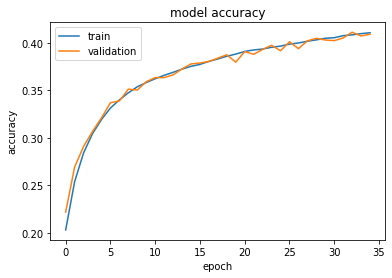

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

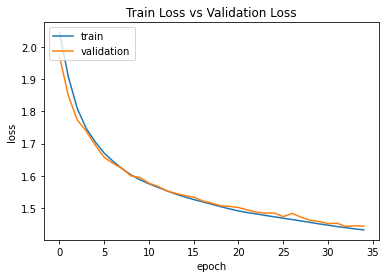

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Train Loss vs Validation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

##Testing

In [ ]:
pred_test = rnn_model.predict(xtest)
y_pred1 = one_hot_encoder.inverse_transform(pred_test)
ytest_decoded = one_hot_encoder.inverse_transform(ytest)

<Figure size 720x720 with 0 Axes>

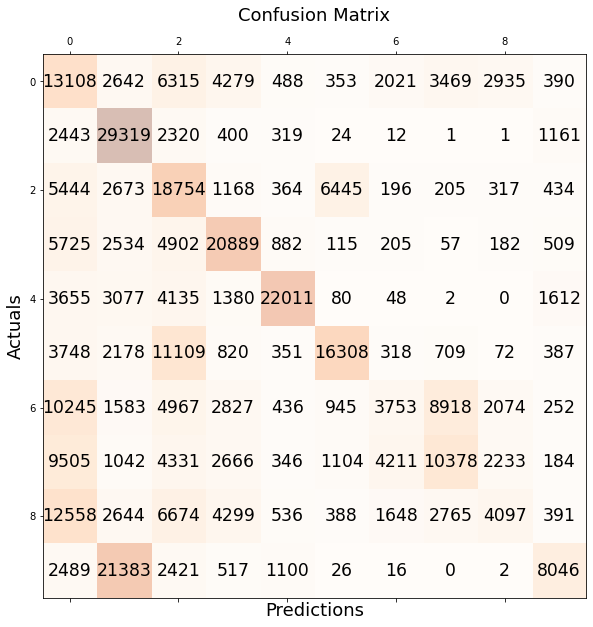

In [ ]:
con_mat = confusion_matrix(ytest_decoded, y_pred1)
plt.figure(figsize = (10, 10))
fig, ax = plt.subplots(figsize=(10, 10))
ax.matshow(con_mat, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(con_mat.shape[0]):
    for j in range(con_mat.shape[1]):
        ax.text(x=j, y=i,s=con_mat[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [ ]:
print(classification_report(ytest_decoded, y_pred1))

              precision    recall  f1-score   support

        8PSK       0.19      0.36      0.25     36000
      AM-DSB       0.42      0.81      0.56     36000
        BPSK       0.28      0.52      0.37     36000
       CPFSK       0.53      0.58      0.56     36000
        GFSK       0.82      0.61      0.70     36000
        PAM4       0.63      0.45      0.53     36000
       QAM16       0.30      0.10      0.15     36000
       QAM64       0.39      0.29      0.33     36000
        QPSK       0.34      0.11      0.17     36000
        WBFM       0.60      0.22      0.33     36000

    accuracy                           0.41    360000
   macro avg       0.45      0.41      0.39    360000
weighted avg       0.45      0.41      0.39    360000

